<a href="https://colab.research.google.com/github/juankuntz/LPAE/blob/master/docs/source/notebooks/MNIST_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we fit an LPAE to the MNIST dataset. For more info on the model and training procedure, see [here](https://lpae.readthedocs.io/en/latest/).

# Setup

We mount drive:

In [1]:
%%capture
# Load drive:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=False) # Mount drive to VM in colab

Load the repository:

In [2]:
# Import github repo:
import sys
!rm -rf langevin_particle_autoencoders
REPOSITORY_PATH = '/content/lpae'
!git clone https://github.com/juankuntz/LPAE.git $REPOSITORY_PATH
if REPOSITORY_PATH not in sys.path:
    sys.path.append(REPOSITORY_PATH)

Cloning into '/content/lpae'...
remote: Enumerating objects: 263, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 263 (delta 0), reused 0 (delta 0), pack-reused 257
Receiving objects: 100% (263/263), 1.09 MiB | 8.63 MiB/s, done.
Resolving deltas: 100% (91/91), done.


And import the modules we need:

In [3]:
# Import modules:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
from tensorflow.keras.layers import Conv2DTranspose, Dense, Reshape
from tensorflow.keras import Sequential
from lpae.src import autoencoders

# Model definition and training

**Training data**: Let's fetch $10,000$ MNIST images to train our model with:

In [4]:
(x, _), (_, _) = tf.keras.datasets.mnist.load_data()
x = tf.constant(x[:10000].astype('float32')[..., np.newaxis])
data = tf.data.Dataset.from_tensor_slices(x)

11490434/11490434 [==============================] - 0s 0us/step


Let's check that these are what we expect:

In [5]:
#@title Definition of plot_images()
def plot_images(image_batch: tf.Tensor, names: list[str] = None) -> None:
  """
  Plots batch of images.

  Parameters
  ----------
  image_batch: tf.Tensor with dimensions (batch_size, 28, 28, 1)
    Batch of images.
  names: list[str] or None
    Corresponding list of names.
  """
  images = [image_batch[i, ...].numpy()[..., 0] 
            for i in range(image_batch.shape[0])]
  if not names:
    names = ['' for _ in images]
  grid_size = math.ceil(len(images) ** (1/2))
  for i, (image, name) in enumerate(zip(images, names)):
      ax = plt.subplot(grid_size, grid_size, i + 1)
      ax.set_title(name)
      plt.imshow(255 - image.astype("uint8"), cmap='Greys')
      plt.axis("off")
  plt.gcf().tight_layout()    
  plt.show()

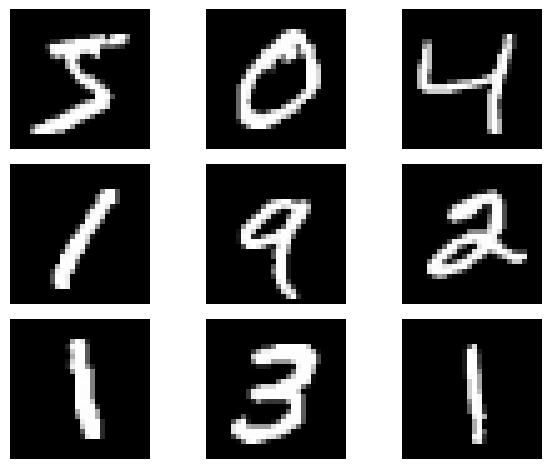

In [6]:
# Plot first nine images:
plot_images(x[:9])

**Model definition**: Next, let's define the model. First, we need to choose the latent space's dimension and then define a decoder mapping from this space to the data space ($\mathbb{R}^{28\times28}$ as we are dealing with $28\times 28$ greyscale images). Let's try $324$ for the dimension and the simple convolutional decoder used in [this keras VAE tutorial](https://keras.io/examples/generative/vae/):

In [8]:
latent_dimensions = 32  
decoder = Sequential([Dense(7 * 7 * 64, activation="relu",
                             input_shape=(latent_dimensions,)),
                       Reshape((7, 7, 64)),
                       Conv2DTranspose(64, 3, activation="relu", strides=2,
                                       padding="same"),
                       Conv2DTranspose(32, 3, activation="relu", strides=2,
                                       padding="same"),
                       Conv2DTranspose(1, 3, activation="sigmoid",
                                       padding="same")
                       ], name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 3136)              103488    
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 28, 28, 1)        289       
 ranspose)                                                       
                                                           

We can now define the entire model:

In [13]:
model = autoencoders.LPAE(latent_dimensions=latent_dimensions,
                          decoder=decoder,
                          observation_noise_std=1e-2)

**Training**: To train it we use:
- $10$ particles,
- a step size of $0.0005$ to update the latent variables,
- and an RMSProp optimizer to update the decoder's parameters.

The decoder's final layer uses a sigmoid activation function, and, so, maps to $[0,1]^{28\times28}$. Hence, we ought to normalize the images so that the lie in $[0,1]^{28\times28}$. We can get the model to handle this internally for us by feeding it to appropiate  `preprocessor` and `postprocessor` layers (the former normalizes, the latter unnormalizes, and both of which must be [keras preprocessing layers](https://www.tensorflow.org/guide/keras/preprocessing_layers)). We have all we need to configure the training:

In [14]:
model.compile(lv_learning_rate=5e-4, n_particles=10,
              optimizer=tf.keras.optimizers.RMSprop(),
              preprocessor=tf.keras.layers.Rescaling(scale=1./255),
              postprocessor=tf.keras.layers.Rescaling(scale=255.))

We can now train the model by calling its fit method, passing in the data, the number of epochs we want it to train for, and the batch size we'd like it to use:

In [15]:
model.fit(data=data, epochs=30, batch_size=256)  

Epoch 1/30


Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.


39/39 [==============================] - 18s 100ms/step - loss: 347778.4750
Epoch 2/30
39/39 [==============================] - 4s 102ms/step - loss: 253475.7887
Epoch 3/30
39/39 [==============================] - 4s 102ms/step - loss: 210243.5398
Epoch 4/30
39/39 [==============================] - 4s 101ms/step - loss: 164244.0836
Epoch 5/30
39/39 [==============================] - 4s 102ms/step - loss: 132808.5826
Epoch 6/30
39/39 [==============================] - 4s 102ms/step - loss: 108716.1729
Epoch 7/30
39/39 [==============================] - 4s 102ms/step - loss: 88913.5662
Epoch 8/30
39/39 [==============================] - 4s 104ms/step - loss: 75042.1297
Epoch 9/30
39/39 [==============================] - 4s 102ms/step - loss: 65018.2279
Epoch 10/30
39/39 [==============================] - 4s 102ms/step - loss: 57066.9476
Epoch 11/30
39/39 [==============================] - 4s 105ms/step - loss: 51256.9106
Epoch 12/30
39/39 [==============================] - 4s 106ms/step 

# Playing around with the fitted model

##Visualizing the posterior

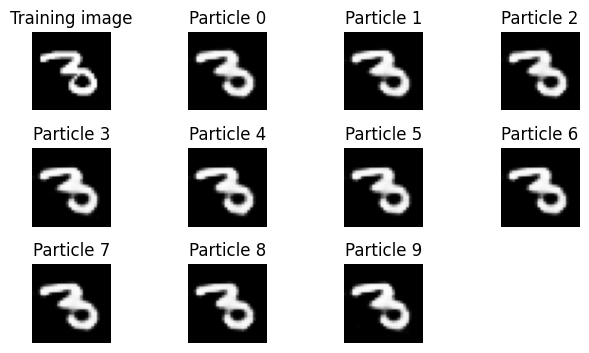

In [29]:
i, n_samples = 30, 10
samples = model.decode_posterior_samples(n_samples=n_samples, index=i)
names = ['Training image'] + [f'Particle {i}' for i in range(n_samples)]
plot_images(tf.concat([x[i][tf.newaxis, ...], samples], axis=0), names)

## Recovering images corrupted with noise

In [30]:
#@title Definition of corrupt()

def corrupt(images: tf.Tensor, noise_intensity: float = 0.3):
    images += noise_intensity * 255 * tf.random.normal(shape=images.shape)
    images *= 1 + noise_intensity * (tf.random.uniform(shape=images.shape) - 0.5)
    return tf.minimum(tf.maximum(images, 0), 255)

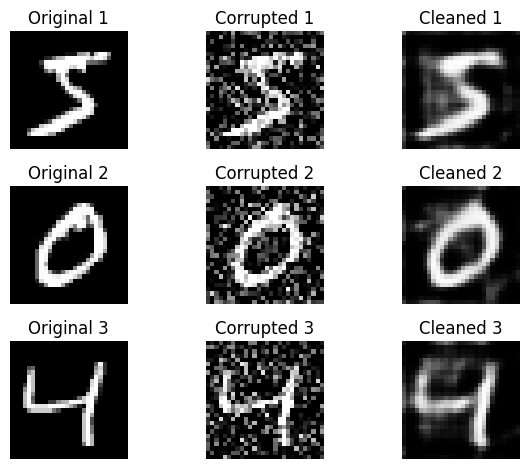

In [31]:
n_images = 3
images = x[:n_images, ...]
corrupted = corrupt(images)
reconstructed = model(corrupted, n_steps=1000)
names = sum([[f'Original {i + 1}', f'Corrupted {i + 1}', f'Cleaned {i + 1}']
             for i in range(n_images)], [])
interweaved = tf.reshape(tf.stack([images, corrupted, reconstructed], axis=1),
                         (3 * n_images,) + images.shape[1:])
plot_images(interweaved, names)

## Generating fakes

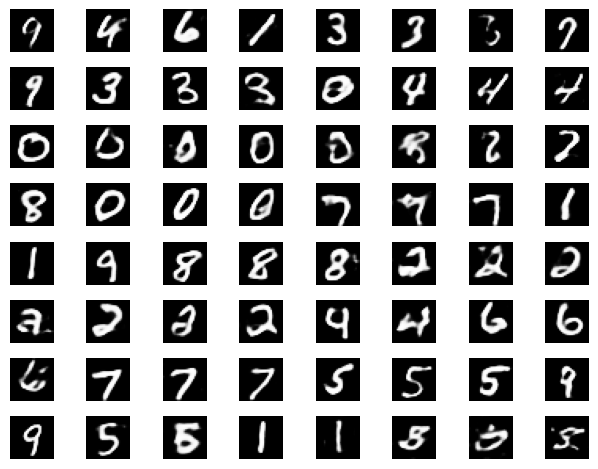

In [32]:
fakes = model.generate_fakes(n_fakes=64, n_components=30)
plot_images(fakes)

#Saving and loading the model

In [33]:
# Save:
#model.save('gdrive/MyDrive/model_ckpt/')
# Load:
#model = models.LangevinParticleAutoencoder.from_save('gdrive/MyDrive/model_ckpt/')